In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
import glob
import string

import nltk
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Topic Modeling
from sklearn import decomposition #for NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD


In [51]:
path = "Patents_xls"
dirs = os.chdir(path)

In [52]:
files = glob.glob('*xlsx')
files

['Huawei.xlsx',
 'Google.xlsx',
 'Pantech.xlsx',
 'Nokia.xlsx',
 'InterDigital.xlsx',
 'Sony Ericsson.xlsx',
 'ZTE.xlsx',
 'HTC.xlsx',
 'Oracle.xlsx',
 'LG.xlsx',
 'Kodak.xlsx',
 'Samsung.xlsx',
 'Apple.xlsx']

In [53]:
docs=[]  #corpus
company_names = []
stopwords = list(ENGLISH_STOP_WORDS)
my_stopwords = ["include","finally", "significant"]
stopwords.extend(my_stopwords)
p = string.punctuation
d = string.digits
combined = p + d

In [54]:
def parse(txt):
    txt = txt.lower()
    #remove punctuation and digits
    table = str.maketrans(combined, len(combined) * " ")
    txt = txt.translate(table)
    #remove stopwords
    words = txt.split()
    cleaned_words = [w for w in words if w not in stopwords]
    cleaned_text = " ".join(cleaned_words)
    return cleaned_text

In [55]:
for f in files:
    df = pd.read_excel(f)
    df['TI'].dropna(inplace=True)
    df['AB'].dropna(inplace = True)
    all_texts=[]
    for index,row in df.iterrows():
        all_texts.append(row['TI'])
        all_texts.append(row['AB'])
    final_text = " ".join(str(t) for t in all_texts)
    cleaned_text = parse(final_text)
    #add this to the docs list
    docs.append(cleaned_text)
    name = f.split("/")[-1][:-5]
    #extracting the company names
    company_names.append(name)    

In [56]:
company_names

['Huawei',
 'Google',
 'Pantech',
 'Nokia',
 'InterDigital',
 'Sony Ericsson',
 'ZTE',
 'HTC',
 'Oracle',
 'LG',
 'Kodak',
 'Samsung',
 'Apple']

In [57]:
# Tfidf Vectorization and cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(docs)
#similarity
similarity = cosine_similarity(dtm)
cos_distance = 1-similarity

#### Performing unsupervised learning algorithms

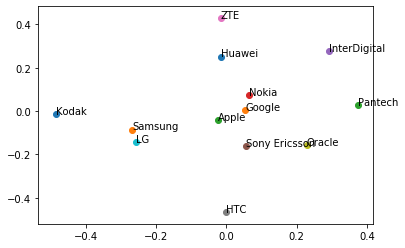

In [58]:
#Multidimensional Scaling
from sklearn.manifold import MDS
mds = MDS(n_components=2,dissimilarity='precomputed',random_state=1)
pos = mds.fit_transform(cos_distance)
xs,ys = pos[:,0],pos[:,1]
for x,y,name in zip(xs,ys,company_names):
    plt.scatter(x,y)
    plt.text(x,y,name)
plt.show()

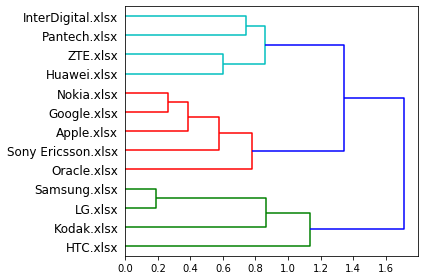

In [59]:
#Hierarchical clustering
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(cos_distance)
dendrogram(linkage_matrix, orientation='right', labels=files)
plt.tight_layout()
plt.show()

In [60]:
#Kmeans clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, random_state=999)
km.fit(dtm) #computes k-means clustering
cluster_membership = km.predict(dtm) #predicts closest cluster
company_distance_to_center = km.transform(dtm) #cluster distance

In [61]:
clusters = zip(cluster_membership, company_names)
print("{0:<15s}{1:<9s}".format("Company_Name","Cluster#"))
for cluster_number, company_name in clusters:
    print("{0:<15s}{1:2d}".format(company_name,cluster_number))

Company_Name   Cluster# 
Huawei          0
Google          1
Pantech         1
Nokia           1
InterDigital    2
Sony Ericsson   1
ZTE             0
HTC             4
Oracle          1
LG              3
Kodak           3
Samsung         3
Apple           1


In [62]:
companies = {'Company': company_names, 'Cluster#': cluster_membership,\
            'Centroid_Dist0':company_distance_to_center[0:,0],\
            'Centroid_Dist1':company_distance_to_center[0:,1],\
            'Centroid_Dist2':company_distance_to_center[0:,2],\
            'Centroid_Dist3':company_distance_to_center[0:,3],\
            'Centroid_Dist4':company_distance_to_center[0:,4]
            }
#let us put into the dataframe
df = pd.DataFrame(companies)
df

,Company,Cluster#,Centroid_Dist0,Centroid_Dist1,Centroid_Dist2,Centroid_Dist3,Centroid_Dist4
0,Huawei,0,0.398403,0.690663,0.985650,0.945163,1.126337e+00
1,Google,1,0.755043,0.346259,0.869938,0.801038,9.738933e-01
2,Pantech,1,0.907099,0.677785,0.996336,0.983263,1.120567e+00
3,Nokia,1,0.630219,0.369741,0.844291,0.838758,9.700533e-01
4,InterDigital,2,0.915410,0.804324,0.000000,1.019595,1.161116e+00
5,Sony Ericsson,1,0.911314,0.486448,1.007784,0.861439,8.541596e-01
6,ZTE,0,0.398403,0.841217,1.010888,1.066094,1.210479e+00
7,HTC,4,1.099191,0.862005,1.161116,0.993947,1.053671e-08
8,Oracle,1,0.884022,0.604360,1.001237,0.938185,1.108507e+00
9,LG,3,0.967539,0.786744,1.064918,0.396716,1.075751e+00


#### Do these unsupervised algorithms yields any similarity?
Yes, they do have similarities. In case of k means clustering the centroid distance from companies and  in case of Multidimensional scaling the distance between each company, whereas in Hierachial clustering the grouping between similar companies. For example Apple,Google,Nokia have almost same distance from their centroids in kmeans, in hierachial clustering we see that Apple,Google,Nokia are grouped into clusters, Similarly in multidimensional scale  they can be seen grouped or with minimum distance to each other.

### Topic Modeling

NMF

In [63]:
vocab = vectorizer.get_feature_names()
num_topics = 5
num_top_words = 20
clf = decomposition.NMF(n_components = num_topics, random_state=1)
doctopic = clf.fit_transform(dtm)
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])


In [64]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: data method user device network second information includes based associated memory application plurality set computer
Topic 1: method layer image second electrode device data light display includes having substrate apparatus liquid organic
Topic 2: device second electronic remote unit portable antenna host nan circuit plurality user communication body tones
Topic 3: method network service invention control packet signal present terminal device communication data gateway media user
Topic 4: communication mobile terminal data method signal channel unit wireless information wtru device power station having


LDA

In [65]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words='english')
num_topics = 5 #arbitrary
dtm_count = count_vectorizer.fit_transform(docs)


In [66]:
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='batch',  max_iter=2000, random_state=0)
document_topics = lda.fit_transform(dtm_count)
feature_names = count_vectorizer.get_feature_names()


In [67]:
def display_topics(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        print("Topic %d:" % (index))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

display_topics(lda, feature_names, 10)


Topic 0:
layer substrate display semiconductor electrode light image gate provided region
Topic 1:
associated application provided message electronic computer node media content received
Topic 2:
station display image message broadcast area hinge rf audio pixel
Topic 3:
display layer electrode substrate liquid crystal gate recording line pixel
Topic 4:
image layer color light images printing material substrate camera surface


LSA/LSI

In [68]:
def get_topics(model, vectorizer, model_name, df, top_n = 20):
        result = []
        for index, topic in enumerate(model.components_): 
            print("Topic %d:" % (index))
            topic_label = model_name + "_topic_" + str(index)   
            score = "SCORE_" + str(index)
            print(" ".join([vocab[i] for i in topic.argsort()[:-top_n - 1:-1]]))
            
print("LSI being performed ...")    # Build a Latent Semantic Indexing Model 

lsi_model = TruncatedSVD(n_components=5, n_iter = 5000)

lsi_Z = lsi_model.fit_transform(dtm)

print(lsi_Z.shape)
# (NO_DOCUMENTS, NO_TOPICS)

print("Generating LSI Model .....")

get_topics(lsi_model, vectorizer, "LSI", pd.DataFrame())



LSI being performed ...
(13, 5)
Generating LSI Model .....
Topic 0:
method data device second communication signal network information includes user mobile terminal unit apparatus image control plurality display invention based
Topic 1:
image layer electrode second light display substrate having organic liquid color device printing gate includes film surface formed crystal material
Topic 2:
electronic device mobile remote portable antenna second communication host nan unit tones body circuit handheld hinge housing board terminal connecting
Topic 3:
terminal mobile communication unit signal channel electrode having display layer wireless crystal pixel area station broadcast substrate hinge liquid gate
Topic 4:
wtru data channel received code wireless signal communication receive transmit apparatus antenna plurality signals ap receiver station wtrus noise using


#### Are these results similar?
Yes, We do have similarity in topics.